##### Working ipynb for explainability in machine learning 

- main goal is to delineate model explainability between Shap, Lime and GAM
- This will act as a shell file on the Austrailian Credit Approval Data until Cap One data is readily available

Import stuff

In [1]:
from __future__ import print_function
from helpful_util import *

import seaborn as sns
import pandas_profiling
from pylab import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')


from collections import Counter

import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split

import seaborn as sns

import keras

#!pip install livelossplot
from livelossplot import PlotLossesKeras
from tensorflow.python.client import device_lib
from keras.losses import binary_crossentropy

from heaton_utils import *

import numpy as np
import warnings
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
import glob
#pip install counter
from collections import Counter

import pickle
import sklearn

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.engine.topology import get_source_inputs
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.optimizers import SGD, adam, adamax, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ReLU, ELU
#!pip install livelossplot
from livelossplot import PlotLossesKeras
from tensorflow.python.client import device_lib
from keras.losses import binary_crossentropy
device_lib.list_local_devices()


rcParams['figure.figsize'] = 5, 5 #Adjust plot size

#files, main_dir = list_dir()
#main_dir
    

Using TensorFlow backend.


In [4]:
list_dir()[1]

Working Dir: C:\Users\jdine\Documents\1.MachineLearning\hicss2020-master
Returning Contents of Working Directory..


{0: '.git',
 1: '.gitignore',
 2: '.ipynb_checkpoints',
 3: 'AustralianCreditApproval.ipynb',
 4: 'data',
 5: 'heaton_utils.py',
 6: 'helpful_util.py',
 7: 'LICENSE',
 8: 'README.md',
 9: 'requirements.py',
 10: '__pycache__'}

In [5]:
#Clean Data
df = load_data(path = 'data', drop_outliers = False, columns = 16, outlier_columns= ['A7', 'A2','A14', 'A13'])


Choose a file from data directory:
0) australian.dat
1) australian.doc
2) ~$stralian.doc
Enter Number: 0
Path to Data Stored: C:\Users\jdine\Documents\1.MachineLearning\hicss2020-master\data\australian.dat
Data Loaded into dataframe


In [5]:
pandas_profiling.ProfileReport(df) #Neat tool for quick EDA

Number of variables,15
Number of observations,690
Total Missing (%),0.0%
Total size in memory,80.9 KiB
Average record size in memory,120.1 B
Numeric,10
Categorical,0
Boolean,5
Date,0
Text (Unique),0
Rejected,0


In [12]:
#g = sns.heatmap(df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [95]:

X_train, X_test, y_train, y_test = split_data(df = df, keras = False, testSize = 0.2, randomState = 123)

data = [X_train, X_test, y_train, y_test]
data_list = ["X_train", "X_test", "y_train", "y_test"]
for i in range(4):
    print(data_list[i], "Shape:")
    print(data[i].shape)


X_train Shape:
(552, 14)
X_test Shape:
(138, 14)
y_train Shape:
(552,)
y_test Shape:
(138,)


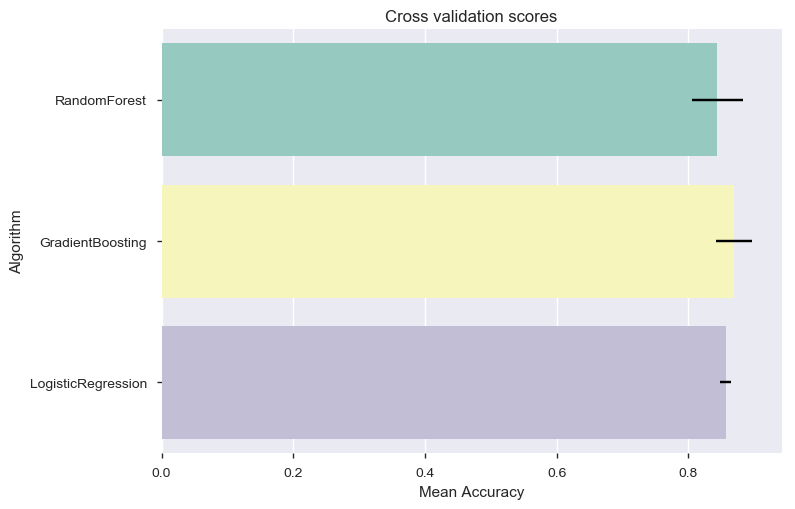

In [8]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)

# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(LogisticRegression(random_state = random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":[
"RandomForest","GradientBoosting","LogisticRegression"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [9]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 6, verbose = 0)
gsRFC.fit(X_train,y_train)
#RFC_best = gsRFC.best_estimator_


# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 6, verbose = 0)
gsGBC.fit(X_train,y_train)
#GBC_best = gsGBC.best_estimator_

#Sklearn Logit Regression
LR = LogisticRegression()
LR_param_grid = {
    'penalty' : ['l1', 'l2']}

gsLR = GridSearchCV(LR, param_grid=LR_param_grid, cv=kfold, scoring="accuracy", n_jobs=6, verbose=0)
gsLR.fit(X_train,y_train)
#LR_best = gsLR.best_estimator_


# Best score
print("RF Best Score: {0:.2f} %".format(gsRFC.best_score_ *100))
print("GBC Best Score: {0:.2f} %".format(gsGBC.best_score_ *100))
print("Logit Best Score: {0:.2f} %".format(gsLR.best_score_ *100))


RF Best Score: 87.32 %
GBC Best Score: 88.04 %
Logit Best Score: 86.05 %


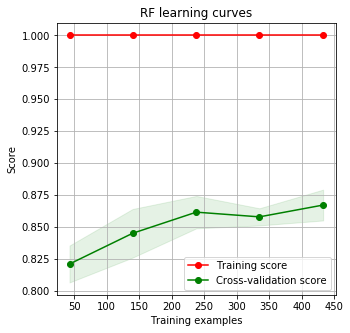

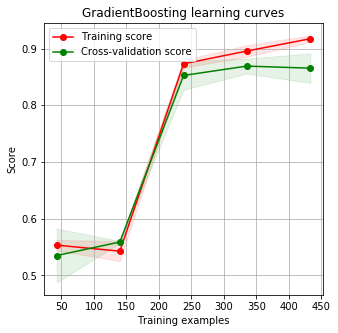

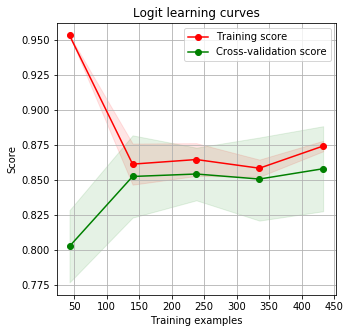

In [15]:
g = plot_learning_curve(gsRFC.best_estimator_,"RF learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gsLR.best_estimator_,"Logit learning curves",X_train,y_train,cv=kfold)

0.8623188405797102
0.8478260869565217
0.855072463768116


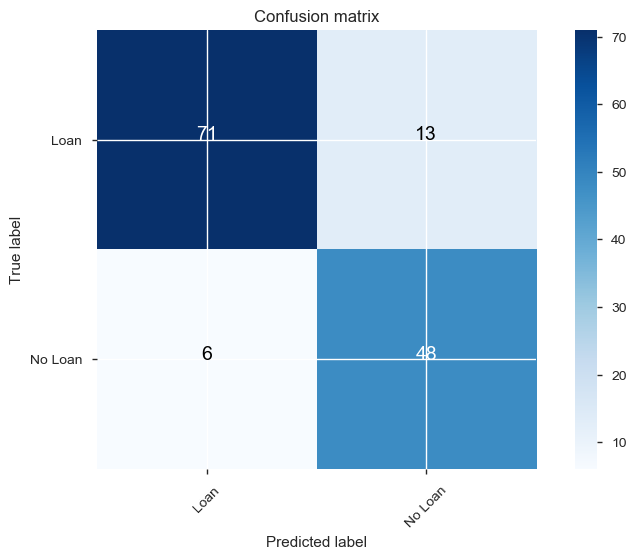

In [44]:
gsRFC.best_estimator_.predict(X_test)
gsGBC.best_estimator_.predict(X_test)
gsLR.best_estimator_.predict(X_test)
class_names = ['Loan', 'No Loan']

print(sklearn.metrics.accuracy_score(y_test, gsRFC.best_estimator_.predict(X_test)))
print(sklearn.metrics.accuracy_score(y_test, gsGBC.best_estimator_.predict(X_test)))
print(sklearn.metrics.accuracy_score(y_test, gsLR.best_estimator_.predict(X_test)))


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, gsRFC.best_estimator_.predict(X_test))
plot_confusion_matrix(cm, classes = class_names)

### Deep Learning 
Building an MLP 

In [37]:
##Using Heaton's Utils
#Built in OHE of explanatory
#!pip install requests
#Use this if we want to OHE dependent var
df = load_data(path = 'data', drop_outliers = False, columns = 16, outlier_columns= ['A7', 'A2','A14', 'A13'])

X_train, X_test, y_train, y_test = split_data(df = df, keras = False, testSize = 0.2, randomState = 123)

data = [X_train, X_test, y_train, y_test]
data_list = ["X_train", "X_test", "y_train", "y_test"]
for i in range(4):
    print(data_list[i], "Shape:")
    print(data[i].shape)



Choose a file from data directory:
0) australian.dat
1) australian.doc
2) ~$stralian.doc
Enter Number: 0
Path to Data Stored: C:\Users\jdine\Documents\1.MachineLearning\hicss2020-master\data\australian.dat
Data Loaded into dataframe
X_train Shape:
(552, 14)
X_test Shape:
(138, 14)
y_train Shape:
(552,)
y_test Shape:
(138,)


In [29]:
from sklearn.preprocessing import MinMaxScaler

df = load_data_gridsearch()
scaler = MinMaxScaler()
x= df[['A2', 'A3', 'A13','A14']]
df[['A2', 'A3', 'A13','A14']] = scaler.fit_transform(x)
df

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,0.125263,0.409286,2,4,4,1.585,0,0,0,1,2,0.0500,0.01212,0
1,0,0.134135,0.250000,2,8,4,0.165,0,0,0,0,2,0.0800,0.00000,0
2,0,0.238045,0.062500,1,4,4,1.250,0,0,0,1,2,0.1400,0.00000,0
3,0,0.119098,0.410714,1,5,3,0.000,1,1,11,1,2,0.0000,0.00000,1
4,1,0.096541,0.291786,2,6,4,1.960,1,1,14,0,2,0.0300,0.00158,1
5,0,0.031278,0.020893,2,8,8,1.500,1,1,2,0,2,0.0500,0.00000,1
6,1,0.055188,0.232143,2,3,4,0.125,0,0,0,0,2,0.0300,0.00100,0
7,0,0.675489,0.159286,2,11,8,3.040,1,1,6,0,2,0.0215,0.00560,1
8,1,0.211729,0.035714,1,2,8,3.000,0,0,0,0,2,0.0880,0.00537,0
9,0,0.631579,0.252857,2,4,8,6.750,1,1,3,1,2,0.0500,0.00050,0


In [ ]:
import numpy as np

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform


def data():
    df = load_data_gridsearch()
    #scaler = MinMaxScaler()
    #x= df[['A2', 'A3', 'A13','A14']]
    #df[['A2', 'A3', 'A13','A14']] = scaler.fit_transform(x)
    X_train, X_test, y_train, y_test = split_data(df = df, keras = True, testSize = 0.2, randomState = 456)
    return X_train, X_test, y_train, y_test


def create_model(x_train, y_train, x_test, y_test):
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')
    #MCP = keras.callbacks.ModelCheckpoint("C:\\Users\\jdine\\Documents\\1.MachineLearning\\hicss2020-master\\model_weights\\best_model.h5",
    #                                      monitor='val_loss', mode='min', verbose=1, save_best_only= True)

    model = Sequential()
    model.add(Dense({{choice([32,64,128,256, 512, 1024])}}, input_shape=(14,)))
    model.add(Activation({{choice(['relu', 'sigmoid', 'tanh', 'elu', 'selu'])}}))
    model.add(Dropout({{uniform(0.2, 1)}}))
    model.add(BatchNormalization(momentum = {{uniform(0, 1)}}))
    model.add(Dense({{choice([32,64,128,256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid', 'tanh', 'elu', 'selu'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(BatchNormalization())
    
    # If we choose 'four', add an additional fourth layer
    if {{choice(['three', 'four'])}} == 'four':
        model.add(Dense({{choice([32,64,128,256, 512, 1024])}}))
        model.add(Activation({{choice(['relu', 'sigmoid', 'tanh', 'elu', 'selu'])}}))
        model.add(Dropout({{uniform(0, 1)}}))
        model.add(BatchNormalization())
    if {{choice(['four', 'five'])}} == 'five':
        model.add(Activation({{choice(['relu', 'sigmoid', 'tanh', 'elu', 'selu'])}}))
        model.add(Dense({{choice([32,64,128,256, 512, 1024])}}))
        model.add(Dropout({{uniform(0, 1)}}))
        model.add(BatchNormalization())
    

    model.add(Dense(2))
    model.add(Activation('sigmoid'))


    with tf.device('/gpu:0'):
        model.compile(loss = 'binary_crossentropy', 
                      optimizer={{choice(['rmsprop', 'adam', 'sgd', 'adagrad', 'adadelta', 'adamax', 'nadam'])}}, 
                      metrics=['accuracy'])
        sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
        result = model.fit(X_train, y_train, batch_size= {{choice([32,64, 128,256])}}, 
                           epochs={{choice([50,100])}}, verbose=2,\
                                validation_split= .2, callbacks=[PlotLossesKeras(), early_stopping])


    #get the highest validation accuracy of the training epochs
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}


best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=10,
                                      trials=Trials(),
                                      notebook_name= 'AustralianCreditApproval',eval_space=True)

X_train, X_test, y_train, y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    from helpful_util import *
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    import pandas_profiling
except:
    pass

try:
    from pylab import rcParams
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import warnings
except:
    pass

try:
    from collections import Counter
except:
    pass

try:
    import sklearn
except:
    pass

try:
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
except:
    pass

try:
    from sklearn.linear_model import LogisticRegression
except:
    pass

try:
    from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    import seaborn as sns
except

Epoch 1/100                                                                                                                                                                     
  0%|                                                                                                                                      | 0/10 [00:01<?, ?it/s, best loss: ?]

In [51]:
ypred = best_model.predict_classes(X_test)


ytest = np.argmax(y_test, axis = 1)

sklearn.metrics.accuracy_score(ytest, ypred)

0.782608695652174